# PACE Metrics

**Required packages:**
- `numpy`
- `pandas`
- `pytorch`
- `scikit-learn`
- `matplotlib`

**Optional packages:**
- `ipython`
- `ipykernel`

**Required python version:** 3.9.x
We cannot use a newer version of python until pytorch adds support for it: https://github.com/pytorch/pytorch/issues/66424

**Installation commands:**

- `/path/to/conda create --name=dl4h-39 python=3.9.12`
- `conda activate dl4h-39`
- `conda install pandas pytables scipy numpy ipython ipykernel pytorch scikit-learn matplotlib`
- `conda install -c conda-forge imbalanced-learn`

## Hyperparameters

## Imports

In [18]:
import csv
import os
import pickle
import datetime

import numpy as np
import pandas as pd

from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, roc_auc_score

import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt

import seaborn as sns

In [11]:
device = "cpu" # torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [48]:
with open("data/test_labels.pkl", "rb") as f:
    test_labels = pickle.load(f)

with open("predictions/prediction_gamma_0.5_lambda_1.3.pkl", "rb") as f:
    base = torch.from_numpy(pickle.load(f))
with open("predictions/prediction_with_modified_loss_gamma_0.5_lambda_1.3.pkl", "rb") as f:
    mod_loss = torch.from_numpy(pickle.load(f))
with open("predictions/prediction_with_modified_loss_with_spl_gamma_0.5_lambda_1.3.pkl", "rb") as f:
    full = torch.from_numpy(pickle.load(f))
with open("predictions/prediction_with_spl_gamma_0.5_lambda_1.3.pkl", "rb") as f:
    spl = torch.from_numpy(pickle.load(f))

## PACE Metrics

In [58]:
def mean(x):
    return sum(x) / len(x)

def compute_metrics(labels, predictions, category):
    metrics = []
    coverages = []
    
    confidences = 0.5 + abs(predictions - 0.5)
    ordered_indices = torch.argsort(confidences, descending=True)
    ordered_outputs = torch.index_select(predictions, 0, ordered_indices).detach().cpu().numpy()
    ordered_labels = torch.index_select(labels, 0, ordered_indices).detach().cpu().numpy()

    for elements_selected in range(1, len(ordered_outputs)+1, 1):
        above_confidence_outputs = ordered_outputs[:elements_selected]
        above_confidence_labels = ordered_labels[:elements_selected]

        metric = 0
        if sum(above_confidence_labels) == 0:# or torch.sum(above_confidence_outputs) == 0:
            metric = sum(above_confidence_outputs < 0.5) / len(above_confidence_labels)
        elif sum(above_confidence_labels) == len(above_confidence_labels):# or torch.sum(above_confidence_outputs) == len(above_confidence_outputs):
            metric = sum(above_confidence_outputs > 0.5) / len(above_confidence_labels)
        else:
            metric = roc_auc_score(above_confidence_labels, above_confidence_outputs)

        coverage = len(above_confidence_outputs) / len(ordered_outputs)

        metrics.append(metric)
        coverages.append(coverage)
    return pd.DataFrame({"metric": (metrics), "coverage": (coverages), "category": [category for i in range(len(metrics))]})

In [59]:
base_df = compute_metrics(test_labels, base, "base")
spl_df = compute_metrics(test_labels, spl, "spl")
mod_loss_df = compute_metrics(test_labels, mod_loss, "mod_loss")
full_df = compute_metrics(test_labels, full, "full")

In [60]:
sns.set_theme()

In [81]:
data = pd.concat([base_df, spl_df, mod_loss_df, full_df])
data = data.reset_index()
data = data.where(data.coverage > 0.1)

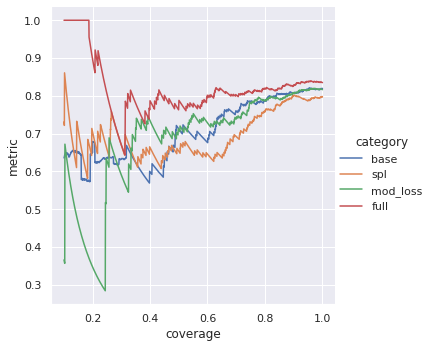

In [82]:
sns.relplot(
    data=data,
    kind="line",
    x="coverage",
    y="metric",
    hue="category"
)